In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import gudhi
from pogo import Pogo
from scipy.sparse import csr_matrix
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from umap import UMAP,plot
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA

from scipy.spatial.distance import is_valid_dm
import seaborn as sns#; sns.set_theme()


/home/a/Desktop/ds/env/lib/python3.8/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/home/a/Desktop/ds/env/lib/python3.8/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/home/a/Desktop/ds/env/lib/python3.8/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


In [2]:
pogo=Pogo()

In [3]:
hf = h5py.File('mouse_ES_cell.h5', 'r')
matrix = np.array(hf.get('X'))
ground_truth = np.array(hf.get('Y'))

In [4]:
hf = h5py.File('Quake_Smart-seq2_Limb_Muscle/data.h5', 'r')


In [5]:
exprs = hf.get('exprs')
np.array(exprs)

array(['data', 'indices', 'indptr', 'shape'], dtype='<U7')

In [6]:
obs = hf.get('obs')
np.array(obs)

array(['cell_ontology_class', 'cell_ontology_id', 'cell_type1', 'channel',
       'cluster', 'dataset_name', 'donor', 'free_annotation', 'gender',
       'organ', 'organism', 'platform', 'region'], dtype='<U19')

In [7]:
ground_truth = np.array(obs.get('cluster'))
ground_truth.shape

(1090,)

In [8]:
uns = hf.get('uns')
np.array(uns)

array(['expressed_genes', 'scmap_genes', 'seurat_genes'], dtype='<U15')

In [9]:
data = np.array(exprs.get('data'))

In [10]:
num_rows = np.array(exprs.get('shape'))[0]
num_columns = np.array(exprs.get('shape'))[1]

In [11]:
print(num_rows)
print(num_columns)

1090
23341


In [12]:
indices = np.array(exprs.get('indices'))

In [13]:
indptr = np.array(exprs.get('indptr'))

In [14]:
matrix = csr_matrix((data, indices, indptr), shape=(num_rows, num_columns)).toarray()

In [15]:
print(matrix.shape)
matrix

(1090, 23341)


array([[  0., 444., 253., ...,   0., 481.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,  19., ...,   0.,   0.,   0.],
       ...,
       [  0., 303.,   0., ...,   0.,  75.,   0.],
       [  0.,   2.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   1., ...,   0.,   0.,   0.]])

In [16]:
cmdist = pdist(matrix, 'correlation')

In [17]:
cmdist.shape

(593505,)

In [18]:
mdist = squareform(cmdist, force='no', checks=True)

In [19]:
mdist.shape

(1090, 1090)

In [20]:
mdist

array([[0.        , 0.63613871, 0.54645528, ..., 0.29636293, 0.48126891,
        0.64589345],
       [0.63613871, 0.        , 0.49509961, ..., 0.58857018, 0.61615674,
        0.65999571],
       [0.54645528, 0.49509961, 0.        , ..., 0.44607569, 0.36835494,
        0.51816641],
       ...,
       [0.29636293, 0.58857018, 0.44607569, ..., 0.        , 0.22051553,
        0.48661743],
       [0.48126891, 0.61615674, 0.36835494, ..., 0.22051553, 0.        ,
        0.39519972],
       [0.64589345, 0.65999571, 0.51816641, ..., 0.48661743, 0.39519972,
        0.        ]])

In [21]:
is_valid_dm(mdist)

True

In [22]:
#Heatmap

#ax = sns.heatmap(mdist,cmap='Spectral')#, vmin=0, vmax=1, center=0.8)

#plt.title('Heatmap')
#plt.savefig('heatmap',dpi=100)

In [23]:
negmdist = np.negative(mdist)
similarity_matrix  = np.exp(negmdist)

CPU times: user 101 ms, sys: 68.1 ms, total: 169 ms
Wall time: 71.5 ms


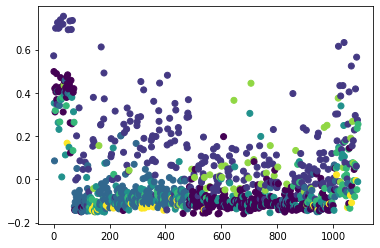

In [24]:
kpca_1d_model = KernelPCA(n_components=1, kernel='precomputed')
%time kpca1 = kpca_1d_model.fit_transform(similarity_matrix)
y = kpca1[:,0]
X = range(len(y))
plt.scatter(X,y,c=ground_truth)

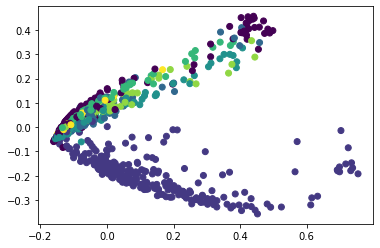

In [25]:

kpca_2d_model = KernelPCA(n_components=2, kernel='precomputed',random_state=42)
kpca2 = kpca_2d_model.fit_transform(similarity_matrix)
X = kpca2[:,0]
y = kpca2[:,1]
plt.scatter(X,y,c=ground_truth)

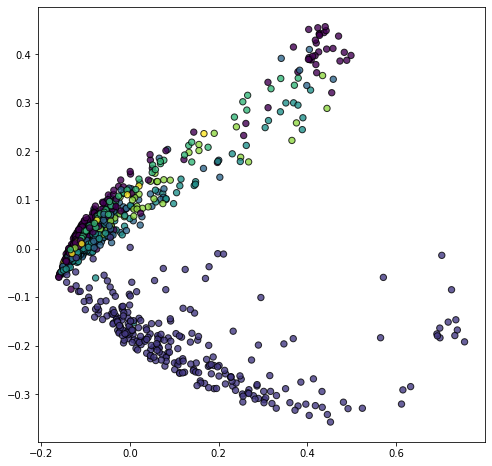

In [26]:

X = kpca2[:,0]
y = kpca2[:,1]
plt.figure(figsize=(8,8))
scatter = plt.scatter(X,y,
            s=40, 
            c=ground_truth,
            marker="o",
            #cmap=viridis,
            norm=None,
            alpha=.8,
            edgecolor="k",
            vmin = 0)

plt.show()

CPU times: user 154 ms, sys: 161 ms, total: 315 ms
Wall time: 111 ms


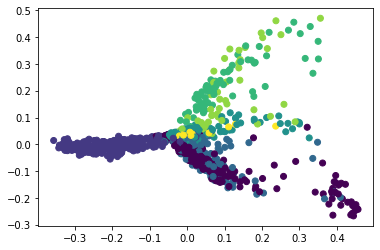

In [27]:
kpca_3d_model = KernelPCA(n_components=3, kernel='precomputed')
%time kpca3 = kpca_3d_model.fit_transform(similarity_matrix)
X = kpca3[:,1]
y = kpca3[:,2]
plt.scatter(X,y,c=ground_truth)

Text(0.5, 0.92, 'KPCA Embedding in 3D')

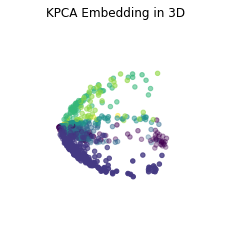

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(kpca3[:,0],kpca3[:,1],kpca3[:,2],c = ground_truth, cmap='viridis')
ax.set_axis_off()

#plt.legend(handles=scatter.legend_elements()[0],bbox_to_anchor=(1,1), labels=list(dict12.keys()))

plt.title('KPCA Embedding in 3D')
#plt.savefig('KPCA Embedding in 3D',dpi=100)

/home/a/Desktop/ds/env/lib/python3.8/site-packages/umap/umap_.py:1503: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(


CPU times: user 10.6 s, sys: 372 ms, total: 11 s
Wall time: 8.6 s


Text(0.5, 1.0, 'Unlabeled UMAP Embedding in 2D')

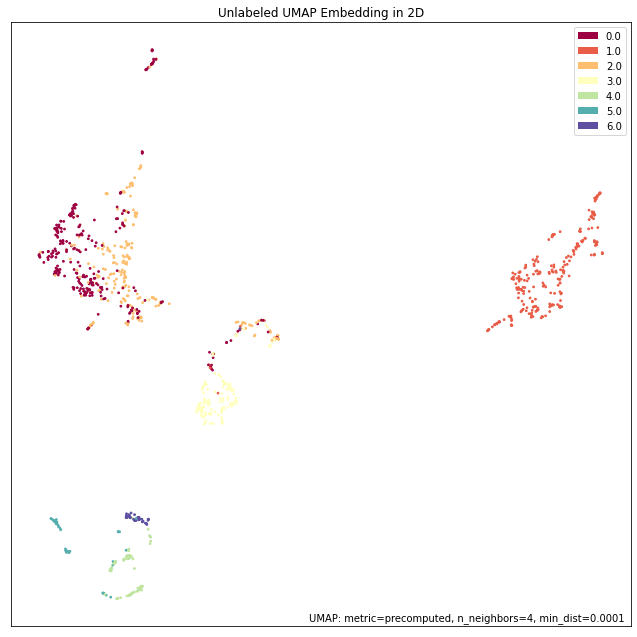

In [29]:
#Create 2-d umap dimensionality reduction embedding to visualize unsupervised models
umap_model_2d = UMAP(metric='precomputed',min_dist=0.0001,n_neighbors=4)
%time umap_embedding = umap_model_2d.fit_transform(mdist)
plot.points(umap_model_2d,labels=ground_truth)

plt.title('Unlabeled UMAP Embedding in 2D')

In [30]:
umap_embedding.shape

(1090, 2)

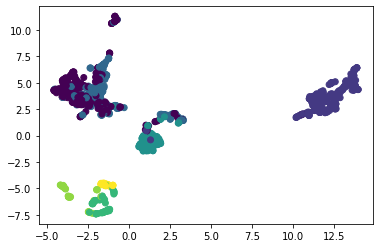

In [31]:
plt.scatter(umap_embedding[:,0], umap_embedding[:,1],c=ground_truth)

In [32]:
#umap_model_33d = UMAP(metric='precomputed',min_dist=0.0001,n_neighbors=4,n_components=33)
#umap_embedding_33d = umap_model_33d.fit_transform(mdist)

In [33]:
#run pogo on embeddings

In [34]:
kpca = KernelPCA(n_components=6, kernel='precomputed')
%time embedding = kpca.fit_transform(similarity_matrix)

CPU times: user 190 ms, sys: 96.2 ms, total: 286 ms
Wall time: 95.8 ms


In [35]:
umap= UMAP(metric='precomputed',min_dist=0.0001,n_neighbors=4,n_components=3)
%time embedding = umap.fit_transform(mdist)

/home/a/Desktop/ds/env/lib/python3.8/site-packages/umap/umap_.py:1503: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(


CPU times: user 5.61 s, sys: 410 ms, total: 6.02 s
Wall time: 3.4 s


usetex mode requires TeX.


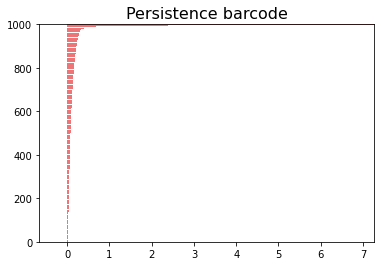

In [36]:
rips_complex = gudhi.RipsComplex(points=embedding)
simplex_tree = rips_complex.create_simplex_tree(max_dimension=1)
diag = simplex_tree.persistence()

gudhi.plot_persistence_barcode(diag)
plt.show()

In [37]:
persistence_module = simplex_tree.persistence()

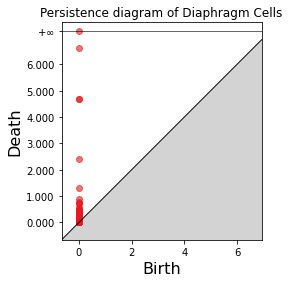

In [38]:
ax = gudhi.plot_persistence_diagram(persistence=persistence_module)
# We can modify the title, aspect, etc.
ax.set_title("Persistence diagram of Diaphragm Cells")
ax.set_aspect("equal")  # forces to be square shaped
plt.show()

In [39]:
%time pogo.fit(embedding)

CPU times: user 54 s, sys: 10 s, total: 1min 3s
Wall time: 54.9 s


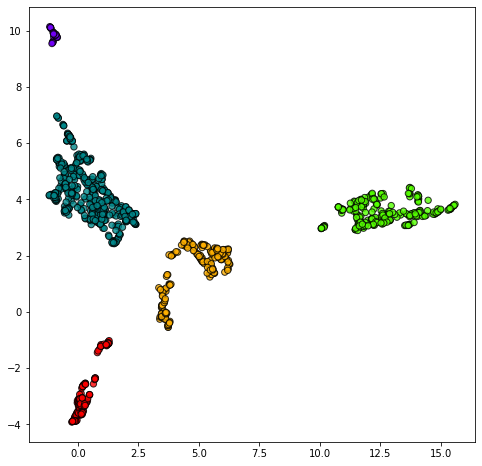

CPU times: user 205 ms, sys: 123 ms, total: 329 ms
Wall time: 183 ms


In [40]:
%time pogo.plot()

In [41]:
pogo.idx_

54182

In [42]:
pogo.candidates_

[113210,
 54182,
 30294,
 182239,
 14311,
 24781,
 11163,
 19663,
 22359,
 8540,
 10523,
 9827,
 7450,
 6519,
 7889,
 7097,
 9436,
 13891,
 8277,
 6883,
 6310,
 5843,
 5198,
 4733,
 10383,
 181938,
 5579,
 5004,
 5451,
 4852,
 4452,
 5087,
 4607,
 4529,
 6218,
 5754,
 9349,
 5339,
 6156,
 4681,
 4944,
 5417,
 6084,
 5552,
 5684,
 4400,
 4432,
 5821,
 4984,
 6130,
 6059,
 5175,
 4722,
 5740,
 5715,
 6043,
 4829,
 5190,
 4521,
 5401,
 4844,
 5394,
 4593,
 5727,
 4602,
 4729,
 4428,
 5336,
 4721,
 5714,
 4983,
 78724,
 78488,
 78738,
 78719,
 78487,
 78720,
 78721,
 78723,
 78726,
 78737,
 78725,
 78486,
 78722,
 78706,
 78736,
 78705,
 78489,
 78490,
 78712,
 78718,
 78499,
 78496,
 78497,
 78716,
 78714,
 78485,
 78498,
 78731,
 78504,
 78707,
 78503,
 78711,
 78500,
 78501,
 78713,
 78733,
 78732,
 78730,
 78729,
 78728,
 78495,
 78491,
 78507,
 78506,
 78708,
 78502,
 78735,
 78505,
 78717,
 78727,
 78734,
 78709,
 78710,
 78492,
 78493,
 78494,
 78715,
 78625,
 78508,
 78578,
 78651,

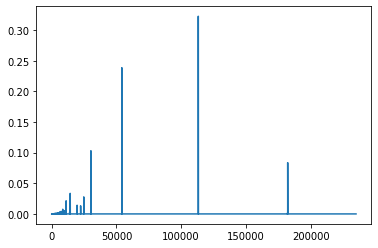

In [43]:
plt.plot(pogo.gap_vector_)

Maximum Silhouette: 54182


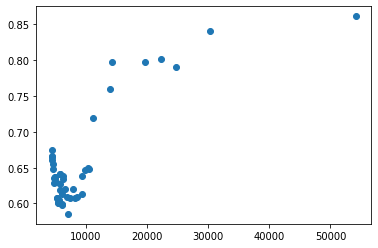

In [44]:
silhouette_indices, silhouette_array = pogo.plot_silhouette()

Maximum Silhouette Score: 54182


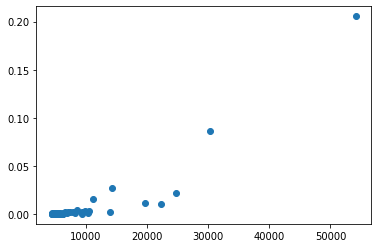

In [45]:
score_indices, score_array = pogo.plot_silhouette_score()

Maximum Rand Score: 19663


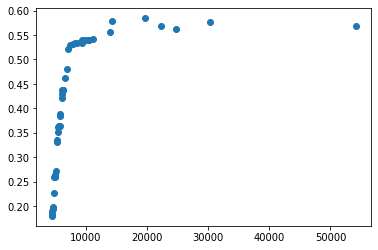

In [46]:
rand_indices, rand_array = pogo.plot_rand_score(ground_truth)


In [47]:
np.argmax(rand_array)

5

In [48]:
max(rand_array)

0.5841971205191304

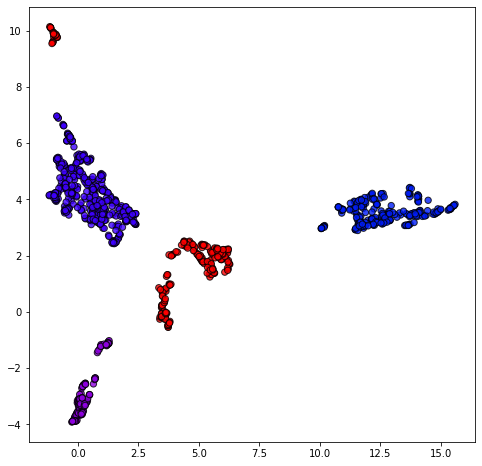

In [49]:
pogo.plot(55000)